In [9]:
import os

# Go up one directory
os.chdir("..")

print("Now in:", os.getcwd())



Now in: c:\Users\visha\Neural-Style-Transfer


## Setup


In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

# Corrected paths using forward slashes
base_image_path = "data/content-images/c1.jpg"
style_reference_image_path = "data/style-images/s1.jpg"
result_prefix = "generated_image"

# Print debugging info to verify paths
print("Working directory:", os.getcwd())
print("Base image exists?", os.path.exists(base_image_path))
print("Style image exists?", os.path.exists(style_reference_image_path))

# Ensure the image paths are correct before continuing
assert os.path.exists(base_image_path), f"Base image not found: {base_image_path}"
assert os.path.exists(style_reference_image_path), f"Style image not found: {style_reference_image_path}"

# Loss weights
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Load image dimensions
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

print("Image dimensions set to:", img_nrows, "x", img_ncols)



Working directory: c:\Users\visha\Neural-Style-Transfer
Base image exists? True
Style image exists? True
Image dimensions set to: 400 x 400


## Let's take a look at our base (content) image and our style reference image


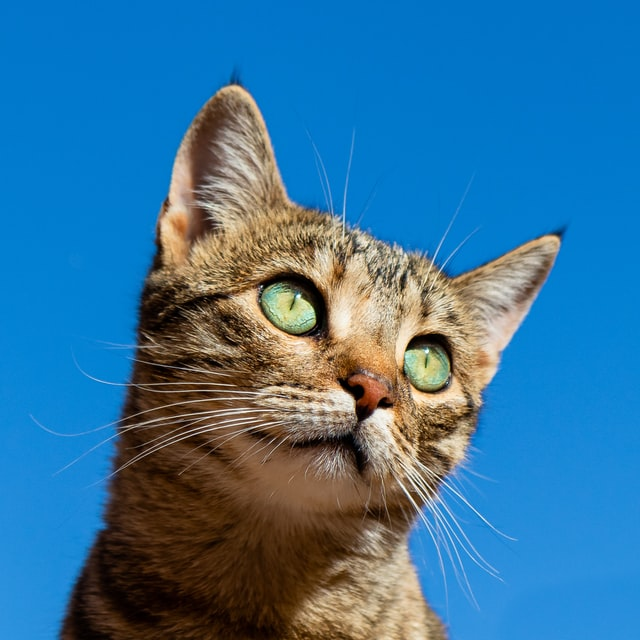

In [13]:
from IPython.display import Image, display

display(Image(base_image_path))


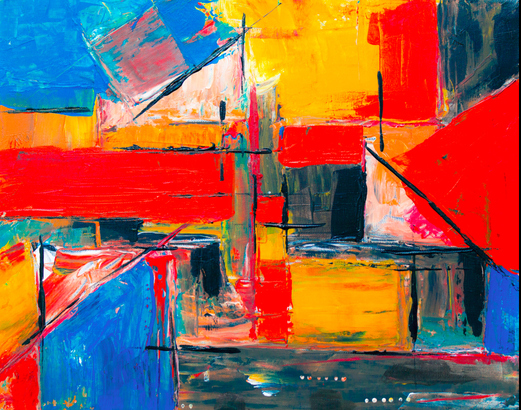

In [14]:
display(Image(style_reference_image_path))

## Image preprocessing / deprocessing utilities


In [15]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x



## Compute the style transfer loss

First, we need to define 4 utility functions:

- `gram_matrix` (used to compute the style loss)
- The `style_loss` function, which keeps the generated image close to the local textures
of the style reference image
- The `content_loss` function, which keeps the high-level representation of the
generated image close to that of the base image
- The `total_variation_loss` function, a regularization loss which keeps the generated
image locally-coherent


In [16]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))



Next, let's create a feature extraction model that retrieves the intermediate activations
of VGG19 (as a dict, by name).


In [17]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Finally, here's the code that computes the style transfer loss.


In [18]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss



## Add a tf.function decorator to loss & gradient computation

To compile it, and thus make it fast.


In [19]:

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads



## The training loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the
resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.


In [22]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TensorFlow to use CPU

import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List all physical devices
for device in tf.config.list_physical_devices():
    print(device)


TensorFlow version: 2.17.1
Num GPUs Available:  0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


 18%|█▊        | 9/50 [00:32<02:27,  3.60s/it]

Iteration 10: loss=36736.11


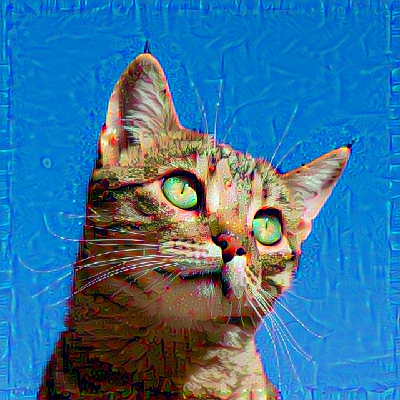

 38%|███▊      | 19/50 [01:10<01:56,  3.74s/it]

Iteration 20: loss=15837.88


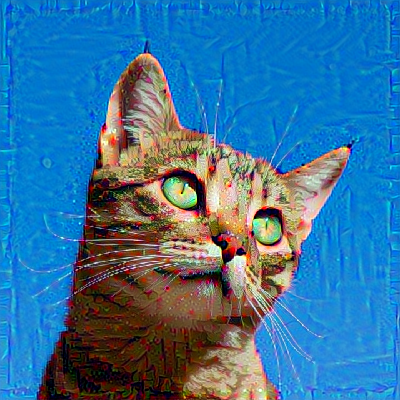

 58%|█████▊    | 29/50 [01:48<01:18,  3.75s/it]

Iteration 30: loss=12928.87


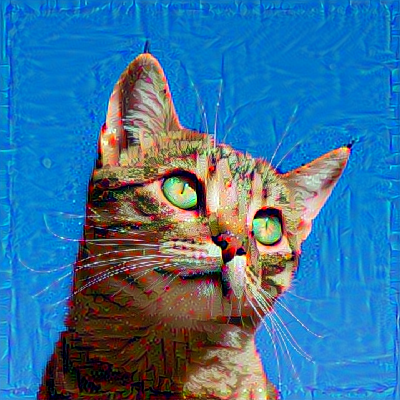

 78%|███████▊  | 39/50 [02:26<00:42,  3.83s/it]

Iteration 40: loss=10294.97


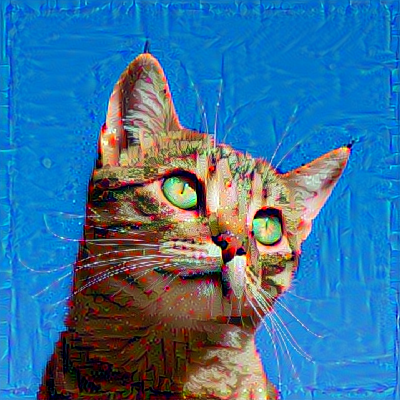

 98%|█████████▊| 49/50 [03:25<00:06,  6.44s/it]

Iteration 50: loss=9771.12


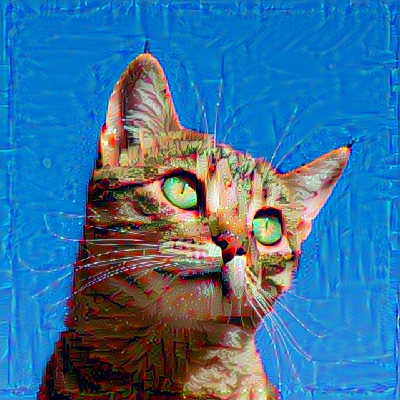

100%|██████████| 50/50 [03:32<00:00,  4.25s/it]


In [28]:
from tqdm import tqdm

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 50
for i in tqdm(range(1, iterations + 1)):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])

    # save image after every 1000 steps
    if i % 10 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)
        display(Image(fname))


After 50000 iterations, you get the following result:


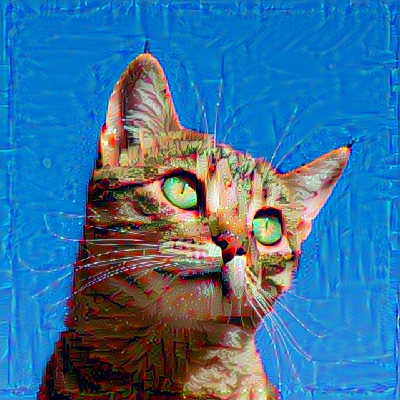

In [30]:
display(Image(result_prefix + "_at_iteration_50.png"))
